# Beer - Choosing the right one for you!

#### We all love beer, but choosing the right one can be difficult! This notebook seeks to help you select the best beers based on online beer reviews.

In [1]:
# ----- Import libraries -----
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

from scipy.stats import norm
from src.beer_utils import *

In [2]:
# ----- Import data and get an overview of the data -----
BEER_DATA_PATH = 'data/beer_reviews.csv'
raw_beer_data = pd.read_csv(BEER_DATA_PATH)
raw_beer_data.head(5)

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


# Can we use all the data?

#### There are some missing values in the data, however the impact of those missing values depends from use case to use case, so we will not remove any rows for now

In [3]:
raw_beer_data.isna().sum()

brewery_id                0
brewery_name             15
review_time               0
review_overall            0
review_aroma              0
review_appearance         0
review_profilename      348
beer_style                0
review_palate             0
review_taste              0
beer_name                 0
beer_abv              67785
beer_beerid               0
dtype: int64

# What makes a good beer?

#### There could be many arguements to what makes a beer good. One of them might be that the higher alcohol volumne by volumne (abv) beer has, the better it is. If that is your mantra, then you could just get your beers from the brewery with the highest average abv

<AxesSubplot:xlabel='brewery_name'>

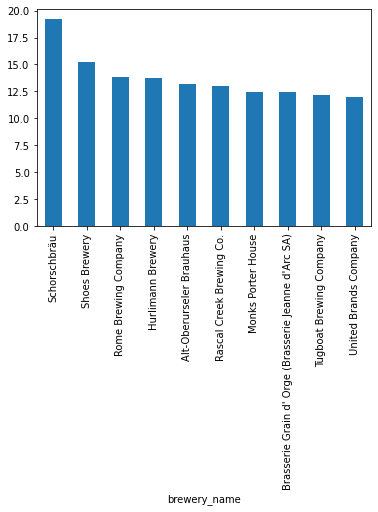

In [4]:
# ----- Find the highest average abv among breweries -----
brewery_average_abv, max_average_abv, max_average_abv_name = highest_abv_by_group(df=raw_beer_data, group_type='brewery_name')
brewery_average_abv.nlargest(10).plot(kind='bar')

#### Or maybe we can find your new favorite beer style based on abv?

<AxesSubplot:xlabel='beer_style'>

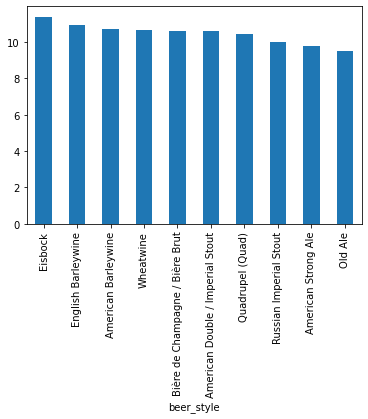

In [5]:
# ----- Find the highest average abv among beer styles -----
beer_type_average_abv, max_average_beer_type_abv, max_average_beer_type_abv_name = highest_abv_by_group(df=raw_beer_data, group_type='beer_style')
beer_type_average_abv.nlargest(10).plot(kind='bar')

# But...Is abv really the only factor to consider when choosing a beer?

#### If we actually want a pleasant experience, we might need to look at other factors that makes a beer great. Luckely we have a LOT of reviews made by beer enthusiasts all around the world, who have rated the beers on different aspects:

In [6]:
raw_beer_data[['review_overall','review_aroma', 'review_appearance', 'review_palate', 'review_taste']].head(5)

,review_overall,review_aroma,review_appearance,review_palate,review_taste
0,1.5,2.0,2.5,1.5,1.5
1,3.0,2.5,3.0,3.0,3.0
2,3.0,2.5,3.0,3.0,3.0
3,3.0,3.0,3.5,2.5,3.0
4,4.0,4.5,4.0,4.0,4.5


#### We want to use these reviews, but how many reviews are enough for us to feel comfortible with the accuracy of the reviews?

#### According to Amazon, there should be atleast 25 reviews on a product before we trust it: https://www.searchenginejournal.com/amazon-product-reviews-best-practices/388179/#close

#### This might be a bit different in the beer world as the people reviewing might be more serious, so lets cut the threshold to atleast 10 reviews for now.

In [7]:
# ----- Remove beers that have less than 10 reviews -----
filtered_beer_data = raw_beer_data[raw_beer_data.groupby('beer_beerid').beer_beerid.transform('count') >= 10]

print(f"Removed: {raw_beer_data.shape[0] - filtered_beer_data.shape[0]} reviews")
print(f"Remaining reviews: {filtered_beer_data.shape[0]}")

Removed: 129994 reviews
Remaining reviews: 1456620


In [8]:
filtered_beer_data.std()

/var/folders/v9/yy3nscw51f7gcvr27jp8_n2m0000gn/T/ipykernel_67689/1040366702.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  filtered_beer_data.std()


brewery_id           5.237802e+03
review_time          7.577260e+07
review_overall       7.150213e-01
review_aroma         6.946780e-01
review_appearance    6.139281e-01
review_palate        6.779123e-01
review_taste         7.273333e-01
beer_abv             2.331480e+00
beer_beerid          2.108888e+04
dtype: float64

#### Furthermore, we will remove rows where a user has reviewed the same beer twice

In [9]:
old_shape = filtered_beer_data.shape[0]
filtered_beer_data.drop_duplicates(['beer_beerid','review_profilename'], inplace=True)

print(f"Removed: {old_shape - filtered_beer_data.shape[0]} reviews")
print(f"Remaining reviews: {filtered_beer_data.shape[0]}")

Removed: 14242 reviews
Remaining reviews: 1442378


/usr/local/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


# So which characteristics are actually important for good reviews?

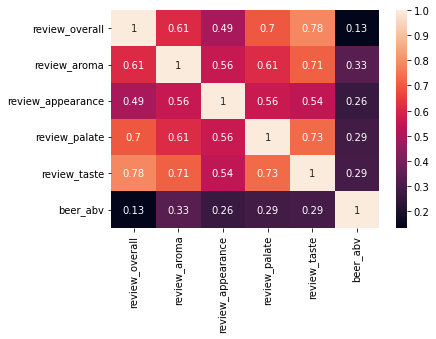

In [10]:
corr_matrix = filtered_beer_data[['review_overall','review_aroma', 'review_appearance', 'review_palate', 'review_taste', 'beer_abv']].corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

#### We can see that the biggest influence to how highly others have rated a beer is Taste, followed by Palate, then Aroma and finally Appearance.

#### It is also worth to note that the beers ABV have a minor impact on the overall rating, so while it is good for getting drunk, it is not a strong indicator for how enjoyable the beer is

# So if we were to suggest the 3 best beers based on these criteria, how should we select them?

#### We know that the different factors of a beer has different impact on the overall rating, so lets save the correlation as weights for later use

In [11]:
# ----- Get correlations and save as weights -----
beer_weights = corr_matrix['review_overall'].to_dict()
del beer_weights['review_overall']
del beer_weights['beer_abv']

In [12]:
beer_weights

{'review_aroma': 0.6074390045937154,
 'review_appearance': 0.49427909459009084,
 'review_palate': 0.6953847501074837,
 'review_taste': 0.7842307297063619}

#### When selecting the beers we also need to consider that reivews might vary. So we create a new dataset where we take the average of each review aspect for each beer

In [13]:
# ----- Get mean values of reviews, grouped by beer id -----
filtered_mean_beer_data = get_mean_review_scores_dataframe(df=filtered_beer_data.copy())

# Now lets figure out which 3 beers that seems safe to recommend

#### We could just recommend the 3 beers with the highest overall rating

In [14]:
filtered_mean_beer_data.sort_values(by=['review_overall'], inplace=True, ascending=False)
filtered_mean_beer_data.head(3)

,beer_beerid,review_overall,review_aroma,review_appearance,review_palate,review_taste,brewery_id,brewery_name,beer_style,beer_name,beer_abv
1396642,63649,4.848485,4.757576,4.469697,4.803030,4.848485,22147,Peg's Cantina & Brewpub / Cycle Brewing,American Double / Imperial Stout,Rare D.O.S.,NaN
1312195,54147,4.846154,4.653846,4.461538,4.538462,4.807692,18149,The Lost Abbey,American Wild Ale,Veritas 005,8.0
1189286,44910,4.820513,4.615385,4.423077,4.576923,4.743590,15237,De Struise Brouwers,Lambic - Unblended,Dirty Horse,7.0


#### However, we could also suggest the 3 beers who have the highest summed review after applying the weights we know are important for a beers score

In [15]:
top_3_beers_with_weights = get_top_n_beers(df=filtered_mean_beer_data.copy(), num_beers=3, weights=beer_weights)
top_3_beers_with_weights

,beer_beerid,review_overall,review_aroma,review_appearance,review_palate,review_taste,brewery_id,brewery_name,beer_style,beer_name,beer_abv,beer_score
903254,24273,4.750000,6.000592,5.470701,6.194341,6.425604,385,Midnight Sun Brewing Co.,American Barleywine,M Belgian-Style Barleywine,11.6,24.091239
1396642,63649,4.848485,5.972454,5.458255,6.193800,6.416946,22147,Peg's Cantina & Brewpub / Cycle Brewing,American Double / Imperial Stout,Rare D.O.S.,NaN,24.041455
1420914,68548,4.730769,5.930263,5.511635,6.060000,6.299231,2216,Brouwerij Drie Fonteinen,Gueuze,Armand'4 Oude Geuze Lente (Spring),6.0,23.801129


#### This would give us a top 3 selection with 2 beers different from just using the top review_overall. And even suggest a beer that is high on abv for the volume lovers!

# Finally, what if you want to select a beer style on your own personal taste?

#### Lets say you prefer beers with a good aroma and a nice appearance. How do you select that? One suggestion could be to select the beer style with the highest average aroma and appearence sum:

In [16]:
beer_type_group = filtered_mean_beer_data.copy().groupby('beer_style')
beer_type_group[['review_appearance', 'review_aroma']].mean().sum(axis=1).sort_values(ascending=False).head(3)

beer_style
Russian Imperial Stout              8.135959
American Double / Imperial Stout    8.118486
American Wild Ale                   8.014622
dtype: float64

#### With this method, a person who enjoys Apperance and Aroma should go after a Russian Imperial Stout

# We could also try and look at the users who seem to value appearance and aroma to see which beer types they prefer

#### To do so, we will select the top 10% of users who have the highest correlation between their overall beer rating and their Appearance/Aroma rating. 

In [17]:
# ----- Group data by profilenames of reviewers -----
reviewer_grp = filtered_beer_data.copy().groupby('review_profilename')

# ----- Create empty dictionary to add new Appearance/Aroma correlation -----
aroma_appearance_dict = {
    'aroma_appearance_enjoyment': [],
    'review_profilename': []
}

# ----- Add each users summed correlation between the overall review and Appearance/Aroma
for profile_name, reviews in reviewer_grp:
    corre = reviews[['review_overall', 'review_aroma', 'review_appearance']].corr()
    aroma_appearance_sum = corre['review_overall']['review_aroma'] + corre['review_overall']['review_appearance']
    if not np.isnan(aroma_appearance_sum):
        aroma_appearance_dict['aroma_appearance_enjoyment'].append(aroma_appearance_sum)
        aroma_appearance_dict['review_profilename'].append(profile_name)

# ----- Create new dataframe based on Appearance/Aroma correlation data -----
aroma_appearance_df = pd.DataFrame(aroma_appearance_dict)

In [18]:
# ----- Add Appearance/Aroma correlation to existing data -----
filtered_beer_data_appearance_aroma = pd.merge(filtered_beer_data.copy(),aroma_appearance_df,how='left',on='review_profilename')

In [19]:
# ----- Get the top ten percent of users who have the highest correlation between their overall rating and their Appearance/Aroma rating ----- -----
users = filtered_beer_data_appearance_aroma.copy().drop_duplicates(subset=['review_profilename'])
users.sort_values(by=['aroma_appearance_enjoyment'], inplace=True, ascending=False)
top_10_percentile_users = users.head(int(len(users)*(10/100)))
users_to_keep = top_10_percentile_users['review_profilename'].tolist()

In [20]:
# ----- Get all reviews from the Appearance/Aroma users -----
appearance_aroma_user_reviews = filtered_beer_data_appearance_aroma[filtered_beer_data_appearance_aroma['review_profilename'].isin(users_to_keep)]

#### Here it seems that the users that value Appearance and Aroma high, have it as a higher correlation to their overall review than when grouping all users together, meaning that Appearance and Aroma are valued around as much as the other two review variables.

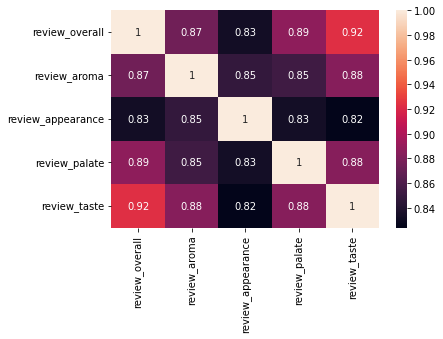

In [21]:
appearance_aroma_user_corr_matrix = appearance_aroma_user_reviews[['review_overall','review_aroma', 'review_appearance', 'review_palate', 'review_taste']].corr()
sn.heatmap(appearance_aroma_user_corr_matrix, annot=True)
plt.show()

In [22]:
# ----- Get mean values of appearance/aroma reviews, grouped by beer id -----
appearance_aroma_user_reviews_mean = get_mean_review_scores_dataframe(df=appearance_aroma_user_reviews.copy())

In [23]:
# ----- Get the highest sum of Appearance and Aroma grouped by beer style -----
beer_type_group_2 = appearance_aroma_user_reviews_mean.copy().groupby('beer_style')
beer_type_group_2[['review_appearance', 'review_aroma']].mean().sum(axis=1).sort_values(ascending=False).head(3)

beer_style
Lambic - Unblended        8.722222
Eisbock                   8.500661
Russian Imperial Stout    8.425066
dtype: float64

#### With this approach, we see that users with a simmilar taste, seem to enjoy Lambic - Unblended.

#### We now have some base recommendations for you based on your taste. However, as soon as you have selected a beer and have given it a review, we can start to compare your taste to other reviewers tastes 